In [14]:
import platform

%pip install -q "openvino>=2023.1.0" opencv-python tqdm

if platform.system() != "Windows":
    %pip install -q "matplotlib>=3.4"
else:
    %pip install -q "matplotlib>=3.4,<3.7"

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


  error: subprocess-exited-with-error
  
  × Building wheel for matplotlib (pyproject.toml) did not run successfully.
  │ exit code: 1
  ╰─> [568 lines of output]
      
      Edit mplsetup.cfg to change the build options; suppress output with --quiet.
      
      BUILDING MATPLOTLIB
            python: yes [3.12.5 (tags/v3.12.5:ff3bc82, Aug  6 2024, 20:45:27) [MSC
                        v.1940 64 bit (AMD64)]]
          platform: yes [win32]
             tests: no  [skipping due to configuration]
            macosx: no  [Mac OS-X only]
      
      C:\Users\usuario\AppData\Local\Temp\pip-build-env-jh7tpytj\overlay\Lib\site-packages\setuptools\dist.py:655: SetuptoolsDeprecationWarning: The namespace_packages parameter is deprecated.
      !!
      
              ********************************************************************************
              Please replace its usage with implicit namespaces (PEP 420).
      
              See https://setuptools.pypa.io/en/latest/referen

In [15]:
import os
from pathlib import Path
from typing import Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import openvino as ov

# Fetch `notebook_utils` module
import requests

r = requests.get(
    url="https://raw.githubusercontent.com/openvinotoolkit/openvino_notebooks/latest/utils/notebook_utils.py",
)

open("notebook_utils.py", "w").write(r.text)

import notebook_utils as utils

In [16]:
# A directory where the model will be downloaded.
base_model_dir = Path("model")
# The name of the model from Open Model Zoo.
detection_model_name = "vehicle-detection-0200"
recognition_model_name = "vehicle-attributes-recognition-barrier-0039"
# Selected precision (FP32, FP16, FP16-INT8)
precision = "FP32"

base_model_url = "https://storage.openvinotoolkit.org/repositories/open_model_zoo/2023.0/models_bin/1"

# Check if the model exists.
detection_model_url = f"{base_model_url}/{detection_model_name}/{precision}/{detection_model_name}.xml"
recognition_model_url = f"{base_model_url}/{recognition_model_name}/{precision}/{recognition_model_name}.xml"
detection_model_path = (base_model_dir / detection_model_name).with_suffix(".xml")
recognition_model_path = (base_model_dir / recognition_model_name).with_suffix(".xml")

# Download the detection model.
if not detection_model_path.exists():
    utils.download_file(detection_model_url, detection_model_name + ".xml", base_model_dir)
    utils.download_file(
        detection_model_url.replace(".xml", ".bin"),
        detection_model_name + ".bin",
        base_model_dir,
    )
# Download the recognition model.
if not os.path.exists(recognition_model_path):
    utils.download_file(recognition_model_url, recognition_model_name + ".xml", base_model_dir)
    utils.download_file(
        recognition_model_url.replace(".xml", ".bin"),
        recognition_model_name + ".bin",
        base_model_dir,
    )

In [17]:
import ipywidgets as widgets

core = ov.Core()

device = widgets.Dropdown(
    options=core.available_devices + ["AUTO"],
    value="AUTO",
    description="Device:",
    disabled=False,
)

device

Dropdown(description='Device:', index=2, options=('CPU', 'GPU', 'AUTO'), value='AUTO')

In [18]:
# Initialize OpenVINO Runtime runtime.
core = ov.Core()
def model_init(model_path: str) -> Tuple:
    """
    Read the network and weights from file, load the
    model on the CPU and get input and output names of nodes

    :param: model: model architecture path *.xml
    :retuns:
            input_key: Input node network
            output_key: Output node network
            exec_net: Encoder model network
            net: Model network
    """

    # Read the network and corresponding weights from a file.
    model = core.read_model(model=model_path)
    compiled_model = core.compile_model(model=model, device_name=device.value)
    # Get input and output names of nodes.
    input_keys = compiled_model.input(0)
    output_keys = compiled_model.output(0)
    return input_keys, output_keys, compiled_model

In [19]:
# de -> detection
# re -> recognition
# Detection model initialization.
input_key_de, output_keys_de, compiled_model_de = model_init(detection_model_path)
# Recognition model initialization.
input_key_re, output_keys_re, compiled_model_re = model_init(recognition_model_path)

# Get input size - Detection.
height_de, width_de = list(input_key_de.shape)[2:]
# Get input size - Recognition.
height_re, width_re = list(input_key_re.shape)[2:]

In [20]:
def plt_show(raw_image):
    """
    Use matplot to show image inline
    raw_image: input image

    :param: raw_image:image array
    """
    plt.figure(figsize=(10, 6))
    plt.axis("off")
    plt.imshow(raw_image)

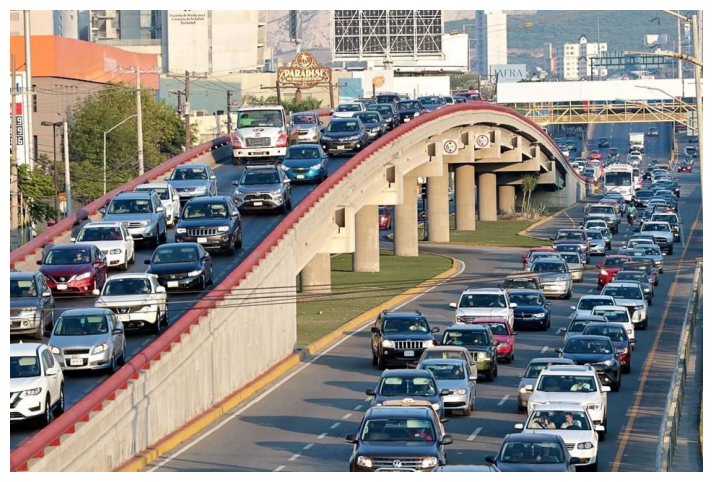

In [21]:
# Load an image.
url = "https://iphonegr.elnorte.com/libre/online07/imagetransformer2/ImageTransformer.aspx?img=https://img.gruporeforma.com/imagenes/960x640/5/571/4570499.jpg&imagencompleta=1"
filename = "traffic.jpg"
directory = "data"
image_file = utils.download_file(
    url,
    filename=filename,
    directory=directory,
    show_progress=False,
    silent=True,
    timeout=30,
)
assert Path(image_file).exists()

# Read the image.
image_de = cv2.imread(f"{directory}/{filename}")
# Resize it to [3, 256, 256].
resized_image_de = cv2.resize(image_de, (width_de, height_de))
# Expand the batch channel to [1, 3, 256, 256].
input_image_de = np.expand_dims(resized_image_de.transpose(2, 0, 1), 0)
# Show the image.
plt_show(cv2.cvtColor(image_de, cv2.COLOR_BGR2RGB))

In [22]:
# Run inference.
boxes = compiled_model_de([input_image_de])[output_keys_de]
# Delete the dim of 0, 1.
boxes = np.squeeze(boxes, (0, 1))
# Remove zero only boxes.
boxes = boxes[~np.all(boxes == 0, axis=1)]

In [23]:
def crop_images(bgr_image, resized_image, boxes, threshold=0.6) -> np.ndarray:
    """
    Use bounding boxes from detection model to find the absolute car position

    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: car_position: car's absolute position
    """
    # Fetch image shapes to calculate ratio
    (real_y, real_x), (resized_y, resized_x) = (
        bgr_image.shape[:2],
        resized_image.shape[:2],
    )
    ratio_x, ratio_y = real_x / resized_x, real_y / resized_y

    # Find the boxes ratio
    boxes = boxes[:, 2:]
    # Store the vehicle's position
    car_position = []
    # Iterate through non-zero boxes
    for box in boxes:
        # Pick confidence factor from last place in array
        conf = box[0]
        if conf > threshold:
            # Convert float to int and multiply corner position of each box by x and y ratio
            # In case that bounding box is found at the top of the image,
            # upper box  bar should be positioned a little bit lower to make it visible on image
            (x_min, y_min, x_max, y_max) = [
                (int(max(corner_position * ratio_y * resized_y, 10)) if idx % 2 else int(corner_position * ratio_x * resized_x))
                for idx, corner_position in enumerate(box[1:])
            ]

            car_position.append([x_min, y_min, x_max, y_max])

    return car_position

In [24]:
# Find the position of a car.
car_position = crop_images(image_de, resized_image_de, boxes)

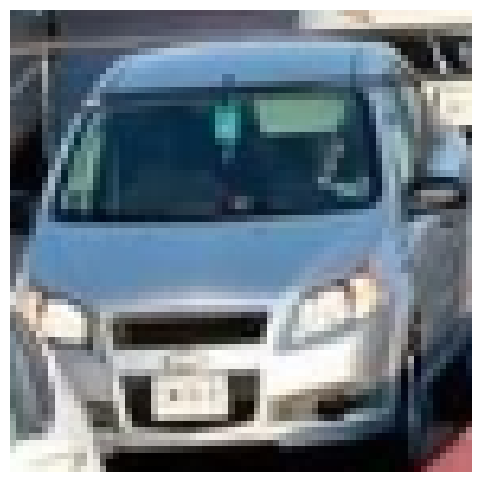

In [25]:
# Select a vehicle to recognize.
pos = car_position[0]
# Crop the image with [y_min:y_max, x_min:x_max].
test_car = image_de[pos[1] : pos[3], pos[0] : pos[2]]
# Resize the image to input_size.
resized_image_re = cv2.resize(test_car, (width_re, height_re))
input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)
plt_show(cv2.cvtColor(resized_image_re, cv2.COLOR_BGR2RGB))

In [26]:
def vehicle_recognition(compiled_model_re, input_size, raw_image):
    """
    Vehicle attributes recognition, input a single vehicle, return attributes
    :param: compiled_model_re: recognition net
    :param: input_size: recognition input size
    :param: raw_image: single vehicle image
    :returns: attr_color: predicted color
                       attr_type: predicted type
    """
    # An attribute of a vehicle.
    colors = ["White", "Gray", "Yellow", "Red", "Green", "Blue", "Black"]
    types = ["Car", "Bus", "Truck", "Van"]

    # Resize the image to input size.
    resized_image_re = cv2.resize(raw_image, input_size)
    input_image_re = np.expand_dims(resized_image_re.transpose(2, 0, 1), 0)

    # Run inference.
    # Predict result.
    predict_colors = compiled_model_re([input_image_re])[compiled_model_re.output(1)]
    # Delete the dim of 2, 3.
    predict_colors = np.squeeze(predict_colors, (2, 3))
    predict_types = compiled_model_re([input_image_re])[compiled_model_re.output(0)]
    predict_types = np.squeeze(predict_types, (2, 3))

    attr_color, attr_type = (
        colors[np.argmax(predict_colors)],
        types[np.argmax(predict_types)],
    )
    return attr_color, attr_type

In [27]:
print(f"Attributes:{vehicle_recognition(compiled_model_re, (72, 72), test_car)}")

Attributes:('Gray', 'Car')


In [28]:
def convert_result_to_image(compiled_model_re, bgr_image, resized_image, boxes, threshold=0.6):
    """
    Use Detection model boxes to draw rectangles and plot the result

    :param: compiled_model_re: recognition net
    :param: input_key_re: recognition input key
    :param: bgr_image: raw image
    :param: resized_image: resized image
    :param: boxes: detection model returns rectangle position
    :param: threshold: confidence threshold
    :returns: rgb_image: processed image
    """
    # Define colors for boxes and descriptions.
    colors = {"red": (255, 0, 0), "green": (0, 255, 0)}

    # Convert the base image from BGR to RGB format.
    rgb_image = cv2.cvtColor(bgr_image, cv2.COLOR_BGR2RGB)

    # Find positions of cars.
    car_positions = crop_images(bgr_image, resized_image, boxes, threshold)

    for x_min, y_min, x_max, y_max in car_positions:
        # Check if the bounding box is valid (ensure it doesn't go out of bounds)
        if x_min < 0 or y_min < 0 or x_max > bgr_image.shape[1] or y_max > bgr_image.shape[0]:
            print(f"Invalid bounding box: {(x_min, y_min, x_max, y_max)}")
            continue  # Skip this invalid bounding box

        # Crop the detected car from the original image.
        cropped_car = bgr_image[y_min:y_max, x_min:x_max]

        # Check if the cropped car image is empty.
        if cropped_car.size == 0:
            print(f"Empty image for bounding box: {(x_min, y_min, x_max, y_max)}")
            continue  # Skip empty images

        # Run vehicle recognition inference.
        attr_color, attr_type = vehicle_recognition(compiled_model_re, (72, 72), cropped_car)

        # Draw a bounding box around the detected car.
        rgb_image = cv2.rectangle(rgb_image, (x_min, y_min), (x_max, y_max), colors["red"], 2)

        # Display the predicted color and type of the vehicle.
        rgb_image = cv2.putText(
            rgb_image,
            f"{attr_color} {attr_type}",
            (x_min, y_min - 10),
            cv2.FONT_HERSHEY_SIMPLEX,
            1,  # Adjust font size to fit text on image
            colors["green"],
            2,
            cv2.LINE_AA,
        )

    return rgb_image


Invalid bounding box: (-3, 359, 62, 456)


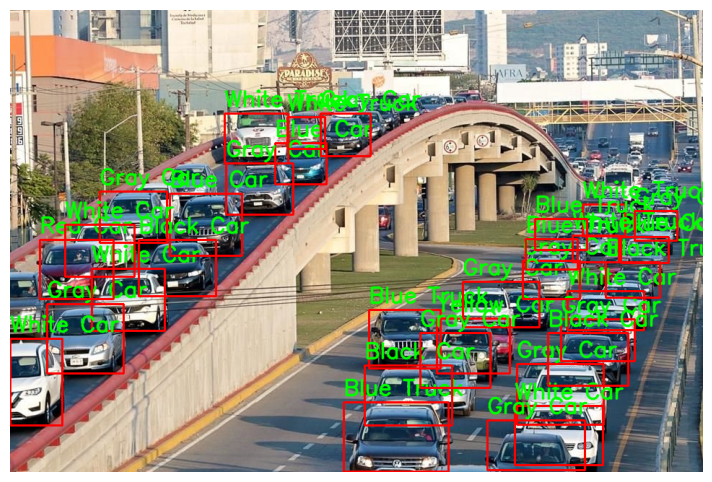

In [29]:
# Display the results with multiple vehicle detections and recognition.
plt_show(convert_result_to_image(compiled_model_re, image_de, resized_image_de, boxes))
